# Week 17
## Ensemble Learning and Random Forest

In [3]:
# Dependencies and modules:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import statsmodels.api as sm

from pprint import pp

from scipy.stats import loguniform, randint, uniform
from sklearn.model_selection import RepeatedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression, BayesianRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, IsolationForest
from xgboost import XGBRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVC

## 1. What is inductive reasoning? Deductive reasoning? Give an example of each, different from the examples given in class.

Deductive reasoning is a logical top-down path where you start with a known, evaluate new information, and follow that information to its logical conclusion. For example, if you know I have three things in my pocket and I pull out a Swiss army knife and a roll of duct tape, you can deduce that I now have one thing in my pocket. 

Inductive reasoning is more bottom-up thinking. You see the hole that was in my hot air balloon is now patched with duct-tape. Then you see that the access panel on the burner has been opened via removal of it's six screws and some faulty wiring has been cut, stripped, and re-connected. You see a Swiss army knife on the floor of the basket surrounded by six screws. You can reason from these observations that I had at least two things in my pocket when boarding the hot air balloon.

## Using ONE of the following sources, complete the questions for only that source. 

Credit approval: https://archive.ics.uci.edu/ml/datasets/Statlog+%28Australian+Credit+Approval%29

Cardiac Arrhythmia: https://archive.ics.uci.edu/ml/datasets/Arrhythmia 

Abalone age: https://archive.ics.uci.edu/ml/datasets/Abalone - this one is a bit harder since it’s not binary like the others, but if you really want to master these concepts, you should pick this one. Use RMSE as a performance metric if you do this as regression. You should target a value of under 3.

#### Note: at least one of your models should have the most relevant performance metric above .90 . All performance metrics should be above .75 . You will partially be graded on model performance.


### Reading in files and creating a dataframe of the data:

In [4]:
# The download consisted of a .names file and a .data file. I will extract column names
# from the .name file for the dataframe that will wold the .data data.

with open("abalone.names") as f:
    print(f.read())

1. Title of Database: Abalone data

2. Sources:

   (a) Original owners of database:
	Marine Resources Division
	Marine Research Laboratories - Taroona
	Department of Primary Industry and Fisheries, Tasmania
	GPO Box 619F, Hobart, Tasmania 7001, Australia
	(contact: Warwick Nash +61 02 277277, wnash@dpi.tas.gov.au)

   (b) Donor of database:
	Sam Waugh (Sam.Waugh@cs.utas.edu.au)
	Department of Computer Science, University of Tasmania
	GPO Box 252C, Hobart, Tasmania 7001, Australia

   (c) Date received: December 1995


3. Past Usage:

   Sam Waugh (1995) "Extending and benchmarking Cascade-Correlation", PhD
   thesis, Computer Science Department, University of Tasmania.

   -- Test set performance (final 1044 examples, first 3133 used for training):
	24.86% Cascade-Correlation (no hidden nodes)
	26.25% Cascade-Correlation (5 hidden nodes)
	21.5%  C4.5
	 0.0%  Linear Discriminate Analysis
	 3.57% k=5 Nearest Neighbour
      (Problem encoded as a classification task)

   -- Data set samp

In [5]:
# abalone.csv
abalone_df = pd.read_csv('abalone.data',header=None, names=['Sex',
                                                            'Length',
                                                            'Diameter',
                                                            'Height',
                                                            'Whole weight',
                                                            'Shucked weight',
                                                            'Viscera weight',
                                                            'Shell weight',
                                                            'Rings',])
abalone_df

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
...,...,...,...,...,...,...,...,...,...
4172,F,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490,11
4173,M,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605,10
4174,M,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080,9
4175,F,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960,10


## 2. Preprocess your dataset. Indicate which steps worked and which didn’t. Include your thoughts on why certain steps worked and certain steps didn’t. 

Here is a recap of various pre-processing we have done over the last month:
* NaN handling (columns vs. rows, fillna vs. dropna, imputation)
* data type handling
* Imbalanced Learning (stratified sampling, oversampling, undersampling)
* outlier detection and/or removal
* standardizing data (regularization, normalizing, scaling)
* feature engineering (categorical vs. numerical vs. strings, binary vs. one-hot, average vs. datetime, extraction vs. tf/idf)
* feature selection (redundant, correlated, dimensionality reduction)

This dataset comes with some pre-processing already done. There are no NaNs, datatypes are numerical (except for sex), and data has been scaled. I will verify these points:

In [6]:
# Verifying documentation-asserted pre-processing:
print('Data variance: ')
print(abalone_df.var(numeric_only=True))
print(' ')
print("Data NaNs: ")
print(abalone_df.isnull().sum().sort_values())
print(' ')
print('Data Types: ')
print(abalone_df.dtypes)

Data variance: 
Length             0.014422
Diameter           0.009849
Height             0.001750
Whole weight       0.240481
Shucked weight     0.049268
Viscera weight     0.012015
Shell weight       0.019377
Rings             10.395266
dtype: float64
 
Data NaNs: 
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64
 
Data Types: 
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object


I first want to create a new column for age, as it is our output variable. Per the dataset documentation, abalone age in years is equal to Rings + 1.5. Then I will factorize the sex column. After that, I will check a heatmap to visualize feature correlation. Then I want to check for outliers with a quick box plot; I can think of scenarious where outliers could be present (an abalone that lived for many years with its length constrained because it was tangled in a plastic net or something). After I scrub outliers, I will perform SMOGN, synthetic minority oversampling for Gaussian noise. Then I will perform a statistical feature selection.

### Feature engineering:

In [7]:
# Age column creation and replacement of Rings column:
abalone_df['Age in years'] = abalone_df['Rings']+1.5
abalone = abalone_df.drop('Rings', axis=1)
abalone.head(2)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age in years
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,16.5
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,8.5


In [8]:
# Factorizing the sex column and preserving a key of sex codes for reference:
column = ['Sex']
for i in column:
    abalone["Coded "+i] = pd.factorize(abalone[i])[0]+1
    code_key = pd.DataFrame(abalone[i])
    code_key["Code for "+i]=abalone["Coded "+i]
    abalone = abalone.drop(i,axis=1)
    print(code_key[[i,"Code for "+i]].value_counts())

Sex  Code for Sex
M    1               1528
I    3               1342
F    2               1307
dtype: int64


In [9]:
abalone.head(2)

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age in years,Coded Sex
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,16.5,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,8.5,1


### Heatmap to show correlation (and multicollinearity):

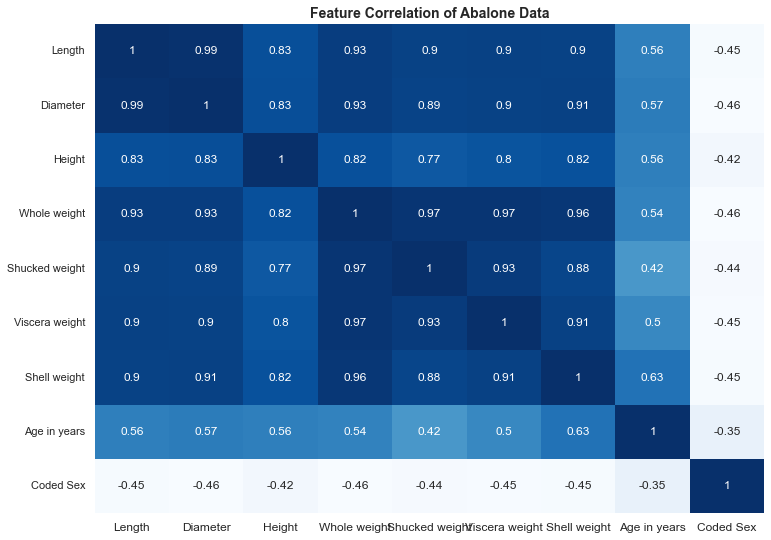

In [11]:
# plotting the heatmap
sns.set(rc={'figure.figsize':(12,9)})

correlation = abalone.corr()
g = sns.heatmap(correlation, annot=True, linewidth=0, cmap="Blues",cbar=False)
g.set_xticklabels(g.get_xticklabels(), rotation = 0, fontsize = 12)
g.set_title('Feature Correlation of Abalone Data',size=14, weight='bold')
sns.set(rc={'figure.figsize':(12,9)})

Obviously the many weight columns have strong multicolinnearity. I will have to cull those down. I will run a feature importance module to determine which should go.

### Box plots to show outliers:

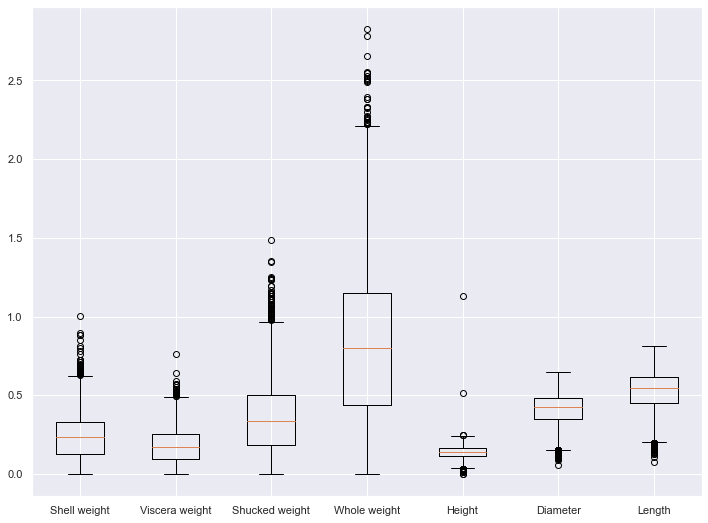

In [12]:
plt.boxplot([abalone['Shell weight'],abalone['Viscera weight'],abalone['Shucked weight'],abalone['Whole weight'],abalone['Height'],abalone['Diameter'],abalone['Length']],labels=['Shell weight', 'Viscera weight','Shucked weight', 'Whole weight', 'Height', 'Diameter', 'Length'])
plt.show()

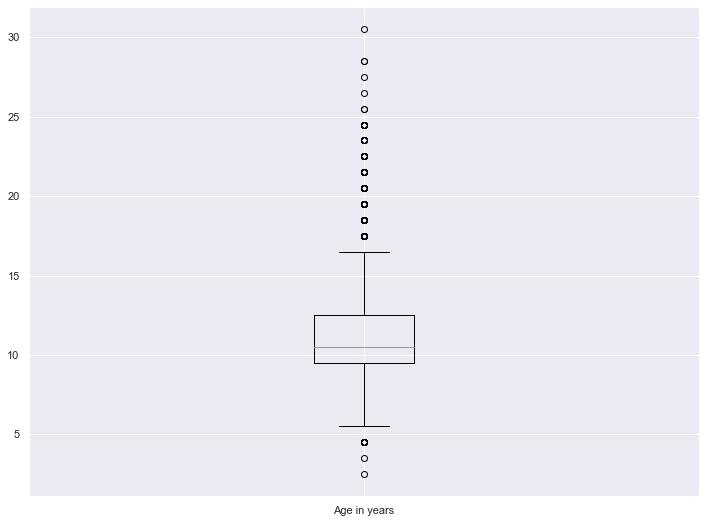

In [13]:
plt.boxplot(abalone['Age in years'],labels= ['Age in years'])
plt.show()

In this visual, we can see that we have outliers in every column. I will try IsolationForest to identify and remove them. I will need to split into test/training sets to move further.

### Random Forest Feature Importance:

In [14]:
# prepare my X and y:
X = abalone.drop('Age in years',axis=1).values
y = abalone['Age in years'].values

# Split into training and test sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=42)
# Examine shape of the training dataset:
print(X_train.shape, y_train.shape)

(2798, 8) (2798,)


Feature: 0, Score: 0.05036
Feature: 1, Score: 0.05533
Feature: 2, Score: 0.05089
Feature: 3, Score: 0.08352
Feature: 4, Score: 0.16476
Feature: 5, Score: 0.07192
Feature: 6, Score: 0.49558
Feature: 7, Score: 0.02764


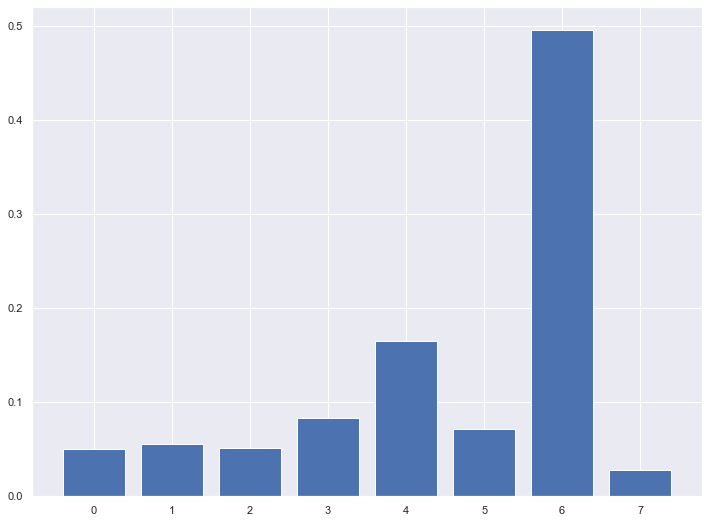

In [17]:
# instantiate my classifier and fit it to my dataset:
rf = RandomForestRegressor(random_state=42)
rf.fit(X,y)

# define the classifier's feature importance property:
importance= rf.feature_importances_

# Report feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# plot the importance for a quick visual:
plt.bar([x for x in range(len(importance))], importance)
plt.show()

Shell weight is the clear winner in the survival game between the weight features. I will drop the others.

#### Since I ran the regresor for the property, I might as well view the model perfomance:

In [18]:
# Baseline performance:
y_pred = rf.predict(X_test)

# Report:
mse = mean_squared_error(y_test, y_pred)
rms = mse**(1/2)

print("MSE = "+str(mse))
print("RMSE = "+str(rms))

MSE = 0.6710109499637419
RMSE = 0.8191525803925309


#### This happens to be the best performing model in the entire assignment! XD I'm going to ignore that, because I need practice playing with pre-procsessing. It is also possible that the columns with strong multicollinearity are making the model look like it's performing better than it actually would IRL.

### Dropping features with strong multicollinearity:

In [19]:
abalone6 = abalone.drop(['Whole weight', 'Viscera weight', 'Shucked weight'],axis=1)
abalone6

,Length,Diameter,Height,Shell weight,Age in years,Coded Sex
0,0.455,0.365,0.095,0.1500,16.5,1
1,0.350,0.265,0.090,0.0700,8.5,1
2,0.530,0.420,0.135,0.2100,10.5,2
3,0.440,0.365,0.125,0.1550,11.5,1
4,0.330,0.255,0.080,0.0550,8.5,3
...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.2490,12.5,2
4173,0.590,0.440,0.135,0.2605,11.5,1
4174,0.600,0.475,0.205,0.3080,10.5,1
4175,0.625,0.485,0.150,0.2960,11.5,2


In [20]:
# preparing my new X and y:
X6 = abalone6.drop('Age in years',axis=1).values
y6 = abalone6['Age in years'].values
# Examine shape:
print(X6.shape, y6.shape)

(4177, 5) (4177,)


In [21]:
# Split the new dataset:
X_train6, X_test6, y_train6, y_test6 = train_test_split(X6, y6, test_size = 0.33, random_state=42)

# Running model again to see difference:
rf6 = RandomForestRegressor()
rf6.fit(X_train6,y_train6)

y_pred6 = rf6.predict(X_test6)

# Report:
mse6 = mean_squared_error(y_test6, y_pred6)
rms6 = mse6**(1/2)

print("MSE = "+str(mse6))
print("RMSE = "+str(rms6))


MSE = 5.68142665220369
RMSE = 2.3835743437542893


#### The model looks like it performed worse, but that could be because strong multicollinearity inflated the previous performance metrics.

### Identifying and removing outliers:

In [22]:
# instantiate my Isolation Forest:
iso = IsolationForest(contamination=0.1)
# identify outliers with module:
y_predo =iso.fit_predict(X6)
# slice for rows that don't have outliers:
mask = y_predo != -1
Xo, yo = X6[mask, :], y6[mask]
# Examine shape of scrubbed training dataset:
print(Xo.shape, yo.shape)

(3759, 5) (3759,)


In [23]:
# The isolation forest identified and removed 418 rows or around 10%
# of the total data. That seems reasonable. Let's see how it affected 
# regression performance:

# Split the modified dataset:
X_traino, X_testo, y_traino, y_testo = train_test_split(Xo, yo, test_size = 0.33, random_state=42)

# instantiate the classifier and fit it to my dataset:
rfo = RandomForestRegressor()
rfo.fit(X_traino, y_traino)

y_pred_rfo = rfo.predict(X_testo) 

# Report:
mseo = mean_squared_error(y_testo, y_pred_rfo)
rmso = mseo**(1/2)

print("MSE = "+str(mseo))
print("RMSE = "+str(rmso))

MSE = 5.489330032702122
RMSE = 2.3429319308725387


That actually worsened performance. I will move forward with these two datasets side-by-side for learning purposes. Next I will use a form of oversampling specifically for regression: SMOGN. 
##### Edit: SMOGN did not work; a problem with the module code. I will move on without SMOGNing.

### Statistical Feature Selection:

#### For whole dataset:

In [24]:
# For Whole Dataset:
#Instantiate my feature selector:
fs = SelectKBest(score_func=f_regression, k=4)
# Fit training data
fs.fit(X_train6, y_train6)
# transform train input data
X_train_fs = fs.transform(X_train6)
#transform test input data
X_test_fs = fs.transform(X_test6)

Feature 0: 1213.871865
Feature 1: 1316.783033
Feature 2: 1167.435214
Feature 3: 1803.909527
Feature 4: 363.896874


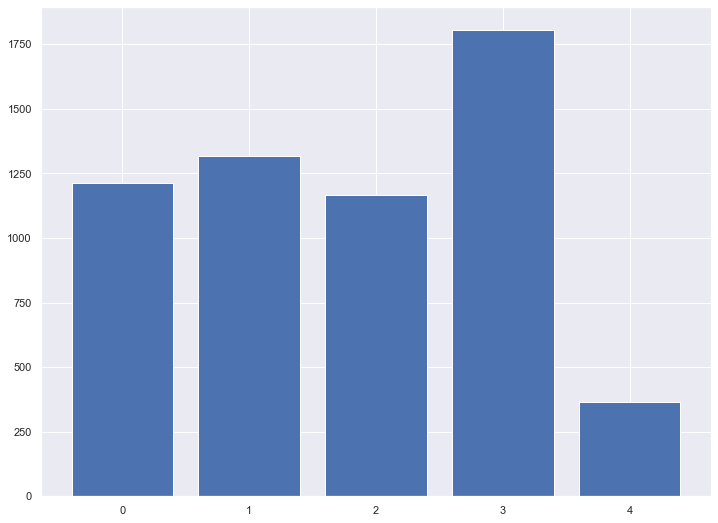

In [25]:
# what are scores for the features
for i in range(len(fs.scores_)):
	print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

#### Ok, I will rerun the selctor, setting k value to 4.

#### For Outlier-removed set:

In [26]:
# Using statistical feature selection on the dataset with outliers removed:

#Instantiate my feature selector:
fso = SelectKBest(score_func=f_regression, k=4)
# Fit training data
fso.fit(X_traino,y_traino)
# transform train input data
X_train_fso = fso.transform(X_traino)
#transform test input data
X_test_fso = fso.transform(X_testo)

Feature 0: 754.706316
Feature 1: 837.747012
Feature 2: 1050.819873
Feature 3: 1286.714113
Feature 4: 386.713284


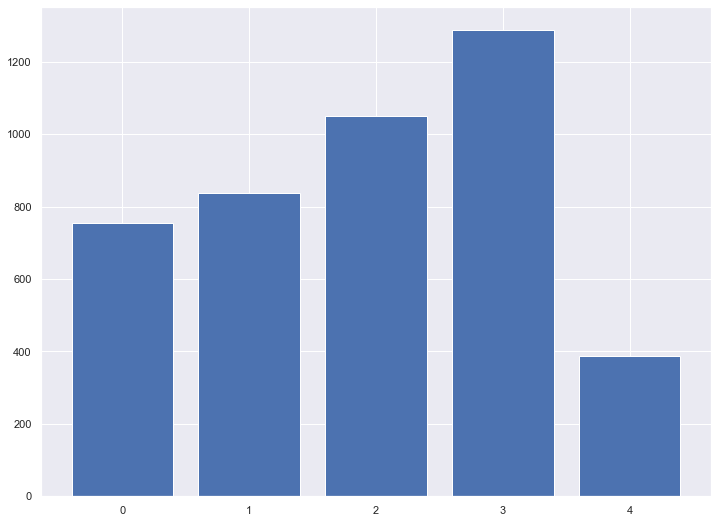

In [27]:
# what are scores for the features
for i in range(len(fso.scores_)):
	print('Feature %d: %f' % (i, fso.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fso.scores_))], fso.scores_)
plt.show()

#### Alright, same thing: k=4.

## 3. Create a decision tree model tuned to the best of your abilities. Explain how you tuned it.

### Running model on whole 6-column dataset:

In [41]:
# Instantiate the classifier and fit it to my dataset:
tree = DecisionTreeRegressor(random_state=42)

# Create the model and get predicted values, timing for performance comparison:
start = time.time()

tree = tree.fit(X_train_fs, y_train6)
y_predt = tree.predict(X_test_fs)

end = time.time()

# Report:
mset = mean_squared_error(y_test6, y_predt)
rmst = mset**(1/2)

print("Time taken to process: ",end-start)
print("MSE = "+str(mset))
print("RMSE = "+str(rmst))

Time taken to process:  0.01562643051147461
MSE = 10.771392313270486
RMSE = 3.281979937975015


### Using RandomizedSearchCV to find best hyperparameters:

In [29]:
# Method of evaluation:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# Creating my search space and filling it with the important hyperparameters:
space = dict()
space['criterion'] = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
space['ccp_alpha'] = loguniform(1e-5, 100)
space['splitter'] = ['best', 'random']

# definingand running the search
search = RandomizedSearchCV(tree, space, n_iter=500, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv, random_state=42)
result = search.fit(X_train_fs, y_train6)

# Report:
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: -2.456324754682308
Best Hyperparameters: {'ccp_alpha': 0.03796617034906454, 'criterion': 'squared_error', 'splitter': 'random'}


### Tuning the parameters made a significant improvement on model performance. I used the RandomizedSearchCV to identify optimum hyperparameter settings instead of GridSearch because Random Search is faster and less processing-intense. I chose hyperparameters to search that optimized accuracy and not on the ones that optimize performance (such as limiting leaf splits or nodes). Beyond that, I referenced Machine Learning Mastery for code setup ideas and for help understanding which hyperparameters were most important for the module. 

### These cells are taking a long time to run, so I am creating an audible alert when my RSCV cells are done running:

In [45]:
from IPython.lib.display import Audio

framerate = 4410
audio_data = 'Bicycle-bell.mp3'
Audio(audio_data, rate=framerate, autoplay=True)

### Outliers Removed:

In [42]:
# Instantiate the classifier and fit it to my whole dataset:
treeo = DecisionTreeRegressor(random_state=42)

# Create the model and get predicted values:
startto = time.time()

treeo = treeo.fit(X_train_fso, y_traino)
y_predto = treeo.predict(X_test_fso)

endto = time.time()

# Report:
mseto = mean_squared_error(y_testo, y_predto)
rmsto = mset**(1/2)

print("Time taken to process: ",endto-startto)
print("MSE = "+str(mseto))
print("RMSE = "+str(rmsto))

Time taken to process:  0.006996870040893555
MSE = 9.898066075745367
RMSE = 3.281979937975015


### Using RandomizedSearchCV to find best hyperparameters:

In [44]:
# Method of evaluation:
cvo = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)
# Creating my search space and filling it with the important hyperparameters:
spaceo = dict()
spaceo['criterion'] = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
spaceo['ccp_alpha'] = loguniform(1e-5, 100)
spaceo['splitter'] = ['best', 'random']

# defining and running the search
searcho = RandomizedSearchCV(treeo, spaceo, n_iter=500, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cvo, random_state=42)
resulto = searcho.fit(X_train_fso, y_traino)

# Report:
print('Best Score: %s' % resulto.best_score_)
print('Best Hyperparameters: %s' % resulto.best_params_)

# Finished alert:
Audio(audio_data, rate=framerate, autoplay=True)

Best Score: -2.3988933619248276
Best Hyperparameters: {'ccp_alpha': 0.0509981061407342, 'criterion': 'friedman_mse', 'splitter': 'best'}


### Final comparison scores for regressor:

In [49]:
# Whole Dataset vs Outlier-removed dataset, side-by-side reports:
print('Decision Tree Regressor')
print(' ')
print('Whole 6-column Dataset Performance')
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
print("Time taken to process: ",end-start)
print(' ')
print('Outlier-removed Dataset Performance')
print('Best Score: %s' % resulto.best_score_)
print('Best Hyperparameters: %s' % resulto.best_params_)
print("Time taken to process: ",endto-startto)

Decision Tree Regressor
 
Whole 6-column Dataset Performance
Best Score: -2.456324754682308
Best Hyperparameters: {'ccp_alpha': 0.03796617034906454, 'criterion': 'squared_error', 'splitter': 'random'}
Time taken to process:  0.01562643051147461
 
Outlier-removed Dataset Performance
Best Score: -2.3988933619248276
Best Hyperparameters: {'ccp_alpha': 0.0509981061407342, 'criterion': 'friedman_mse', 'splitter': 'best'}
Time taken to process:  0.006996870040893555


### Again, it is obvious that big gains are to be had by tuning the model. This instance shows that the extra layers of pre-processing squeaked me out a tiny bit more accuracy on the un-tuned model, but tuned performance is almost identical.

## 4. Create a random forest model tuned to the best of your abilities. Explain how you tuned it.

### Whole 6-column dataset:

In [50]:
# Code from my check up above, with added timer:
rf6 = RandomForestRegressor(random_state=42)

startrf6 = time.time()

rf6.fit(X_train6,y_train6)

y_pred6 = rf6.predict(X_test6)

endrf6 = time.time()

# Report:
mse6 = mean_squared_error(y_test6, y_pred6)
rms6 = mse6**(1/2)

print("Time taken to process: ", endrf6-startrf6)
print("MSE = "+str(mse6))
print("RMSE = "+str(rms6))

Time taken to process:  0.5346066951751709
MSE = 5.63095310005155
RMSE = 2.3729629369317067


### Using RandomizedSearchCV to find best hyperparameters:

In [63]:
# Creating my search space and filling it with the important hyperparameters:
spacerf = dict()
spacerf['criterion'] = ['squared_error', 'absolute_error', 'poisson']
spacerf['ccp_alpha'] = loguniform(1e-5, 100)
spacerf['bootstrap'] = [True]
spacerf['oob_score'] = [True,False]
spacerf['max_samples'] = randint(100,1000)
spacerf['n_estimators'] = randint(24,1000)

# defining and running the search
searchrf = RandomizedSearchCV(rf6, spacerf, n_iter=20, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv, random_state=42)
resultrf = searchrf.fit(X_train_fs, y_train6)

# Report:
print('Best Score: %s' % resultrf.best_score_)
print('Best Hyperparameters: %s' % resultrf.best_params_)

# Finished alert:
Audio(audio_data, rate=framerate, autoplay=True)

Best Score: -2.2752029553024955
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0019310138185083825, 'criterion': 'absolute_error', 'max_samples': 826, 'n_estimators': 275, 'oob_score': True}


### Outlier-removed dataset:

In [52]:
# Code from my check up above:
rfo = RandomForestRegressor(random_state=42)

startrfo = time.time()
rfo.fit(X_traino, y_traino)

y_predo = rfo.predict(X_testo)
endrfo = time.time()

# Report:
mserfo = mean_squared_error(y_testo, y_predo)
rmsrfo = mserfo**(1/2)

print("Time taken to process: ", endrfo-startrfo)
print("MSE = "+str(mse6))
print("RMSE = "+str(rms6))

Time taken to process:  0.4721052646636963
MSE = 5.63095310005155
RMSE = 2.3729629369317067


### Using RandomizedSearchCV to find best hyperparameters:

In [64]:
# Creating my search space and filling it with the important hyperparameters:
spacerfo = dict()
spacerfo['criterion'] = ['squared_error', 'absolute_error', 'poisson']
spacerfo['ccp_alpha'] = loguniform(1e-5, 100)
spacerfo['bootstrap'] = [True]
spacerfo['oob_score'] = [True,False]
spacerfo['max_samples'] = randint(100,1000)
spacerfo['n_estimators'] = randint(24,1000)

# defining and running the search
searchrfo = RandomizedSearchCV(rfo, spacerfo, n_iter=20, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv, random_state=42)
resultrfo = searchrfo.fit(X_train_fso, y_traino)

# Report:
print('Best Score: %s' % resultrfo.best_score_)
print('Best Hyperparameters: %s' % resultrfo.best_params_)

# Finished alert:
Audio(audio_data, rate=framerate, autoplay=True)

Best Score: -2.245024458356303
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 2.5502648504032844e-05, 'criterion': 'squared_error', 'max_samples': 199, 'n_estimators': 895, 'oob_score': False}


### Final comparison scores for regressor:

In [65]:
# Whole Dataset vs Outlier-removed dataset, side-by-side reports:
print('Random Forest Regressor')
print(' ')
print('Whole 6-column Dataset Performance')
print('Best Score: %s' % resultrf.best_score_)
print('Best Hyperparameters: %s' % resultrf.best_params_)
print("Time taken to process: ", endrf6-startrf6)
print(' ')
print('Outlier-removed Dataset Performance')
print('Best Score: %s' % resultrfo.best_score_)
print('Best Hyperparameters: %s' % resultrfo.best_params_)
print("Time taken to process: ",endrfo-startrfo)

Random Forest Regressor
 
Whole 6-column Dataset Performance
Best Score: -2.2752029553024955
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0019310138185083825, 'criterion': 'absolute_error', 'max_samples': 826, 'n_estimators': 275, 'oob_score': True}
Time taken to process:  0.5346066951751709
 
Outlier-removed Dataset Performance
Best Score: -2.245024458356303
Best Hyperparameters: {'bootstrap': True, 'ccp_alpha': 2.5502648504032844e-05, 'criterion': 'squared_error', 'max_samples': 199, 'n_estimators': 895, 'oob_score': False}
Time taken to process:  0.4721052646636963


I tried to focus on prediction optimization hyperparameters instead of performace optimization hyperparameters.  In my first few tests, I had verbosity turned on and I enjoyed the reports. But this provided a messier output, so I turned them off.\
 I set bootstrap to True with no option for False because I kept getting fit errors as the Search tried to match bootstrap=False with max_samples parameter.
I also wanted to set max_samples to the range of (0.0,1.0] but couldn't figure out a syntax that wouldn't make the Search angry.

For this regressor, dropped number of iterations from 500 (which was taking literal days) to a pathetic 20. But, seriously, *ain't nobody got time for that!* \
It was a good learning experience, regardless. I again relied heavily on Machine Learning Mastery articles for ideas on what parameters are most important for this module.

## 5. Create an xgboost model tuned to the best of your abilities. Explain how you tuned it. 

### Whole 6-column dataset:

In [56]:
# instantiate my regressor and fit it to my model, with processing timer:
xgb = XGBRegressor(random_state=42)

startxgb = time.time()

xgb.fit(X_train_fs, y_train6)

# Get my predictions:
y_predx = xgb.predict(X_test_fs)

endxgb = time.time()

# Report:
msex = mean_squared_error(y_test6, y_predx)
rmsx = msex**(1/2)

print("Time taken to process: ", endxgb-startxgb)
print("MSE = "+str(msex))
print("RMSE = "+str(rmsx))

Time taken to process:  0.284121036529541
MSE = 6.034912337422411
RMSE = 2.4566058571578817


### Using RandomizedSearchCV to find best hyperparameters:

In [66]:
# Creating my search space and filling it with the important hyperparameters:
spacex = dict()
spacex['max_depth'] = np.arange(3,18,1)
spacex['gamma'] = np.arange(1,9)
spacex['reg_alpha'] = np.arange(40,180,1)
spacex['reg_lambda'] = np.arange(0,1)
spacex['colsample_bytree'] = np.arange(0.5,1)
spacex['min_child_weight'] = np.arange(0, 10,1)
spacex['n_estimators'] = randint(24,1000)

# defining and running the search
searchx = RandomizedSearchCV(xgb, spacex, n_iter=20, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv, random_state=42)
resultx = searchx.fit(X_train_fs, y_train6)

# Report:
print('Best Score: %s' % resultx.best_score_)
print('Best Hyperparameters: %s' % resultx.best_params_)

# Finished alert:
Audio(audio_data, rate=framerate, autoplay=True)

Best Score: -2.3191227916261794
Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 1, 'max_depth': 13, 'min_child_weight': 9, 'n_estimators': 499, 'reg_alpha': 54, 'reg_lambda': 0}


### Outlier-removed dataset:

In [58]:
# instantiate my regressor and fit it to my model
xgbo = XGBRegressor(random_state=42)

startxgbo = time.time()
xgbo.fit(X_train_fso, y_traino)

# Get my predictions:
y_predxo = xgbo.predict(X_test_fso)
endxgbo = time.time()

# Report:
msexo = mean_squared_error(y_testo, y_predxo)
rmsxo = msexo**(1/2)

print("Time taken to process: ", endxgbo-startxgbo)
print("MSE = "+str(msexo))
print("RMSE = "+str(rmsxo))

Time taken to process:  0.2576115131378174
MSE = 5.906766288305592
RMSE = 2.430383979601905


### Using RandomizedSearchCV to find best hyperparameters:

In [70]:
# Creating my search space and filling it with the important hyperparameters:
spacexo = dict()
spacexo['max_depth'] = randint(3,18)
spacexo['gamma'] = randint(1,9)
spacexo['reg_alpha'] = randint(40,180)
spacexo['reg_lambda'] = randint(0,1)
spacexo['colsample_bytree'] = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,.7,0.8,0.9,1.0]
spacexo['min_child_weight'] = randint(0, 10)
spacexo['n_estimators'] = randint(24,1000)

# defining and running the search
searchxo = RandomizedSearchCV(xgbo, spacexo, n_iter=20, scoring='neg_root_mean_squared_error', n_jobs=-1, cv=cv, random_state=42)
resultxo = searchxo.fit(X_train_fso, y_traino)

# Report:
print('Best Score: %s' % resultxo.best_score_)
print('Best Hyperparameters: %s' % resultxo.best_params_)

# Finished alert:
Audio(audio_data, rate=framerate, autoplay=True)

Best Score: -2.2829922590447427
Best Hyperparameters: {'colsample_bytree': 0.7, 'gamma': 2, 'max_depth': 11, 'min_child_weight': 8, 'n_estimators': 180, 'reg_alpha': 54, 'reg_lambda': 0}


### Final comparison scores for regressor:

In [72]:
# Whole Dataset vs Outlier-removed dataset, side-by-side reports:
print('XGBoost Regressor')
print(' ')
print('Whole 6-column Dataset Performance')
print('Best Score: %s' % resultx.best_score_)
print('Best Hyperparameters: %s' % resultx.best_params_)
print("Time taken to process: ", endxgb-startxgb)
print(' ')
print('Outlier-removed Dataset Performance')
print('Best Score: %s' % resultxo.best_score_)
print('Best Hyperparameters: %s' % resultxo.best_params_)
print("Time taken to process: ",endxgbo-startxgbo)

XGBoost Regressor
 
Whole 6-column Dataset Performance
Best Score: -2.3191227916261794
Best Hyperparameters: {'colsample_bytree': 0.5, 'gamma': 1, 'max_depth': 13, 'min_child_weight': 9, 'n_estimators': 499, 'reg_alpha': 54, 'reg_lambda': 0}
Time taken to process:  0.284121036529541
 
Outlier-removed Dataset Performance
Best Score: -2.2829922590447427
Best Hyperparameters: {'colsample_bytree': 0.7, 'gamma': 2, 'max_depth': 11, 'min_child_weight': 8, 'n_estimators': 180, 'reg_alpha': 54, 'reg_lambda': 0}
Time taken to process:  0.2576115131378174


### XGBRegressor is huge and powerful and I admit that I felt out of my depth while working with it. I coldn't find as much documentation on the hyperparameters and it was confusing trying to understand the different organization structure of the documentation for XGBoost module. I couldn't find a list of hyperparameters specific to the regressor, for instance. However, it did net the best overall model performance and I'm sure a power user could do even better with it. This is definately a module I want to increase my skill with.

## 7. Which model performed best? What is your performance metric? Why? 

I have been trying to create ML models to estimate the age of ablone based on physical traits as an alternative to manually determining the true age. I have been using regression models to make predictions. Considering these things, performance metric that makes the most sense for this dataset is root mean squared error. This is for a few reasons: the metric that is usually considered the measure of accuracy, R^2, is not a good metric in this instance. R^2 does'nt measure goodness of fit, nor does it measure predictive error. Another metric we've been using a lot in class is mean sqared error. This is not the best metric for this dataset, either. The data has been scaled, wich makes mean squared error less reliable. Also, mean squared error penalizes large errors less than other metrics. Large errors would make the model useless to the ecologists or biologists that need to use it. Therefore, root mean squared error is the metric that I have used to judge model performance. Taking the root before the average not only works better for data on a similar scale, but it also heavily penalizes large errors. 

The RMSEs were pretty comparable amongst the various models once each model was tuned appropriately. The model with the best possible RSME score was RandomForest. However, although XGBRegressor's RMSE was just a *skosh* higher, it took half the time to process! This is probably because XGBoost is a module that learns from each successive tree it builds and adjusts in real time. 

Outlier removal did end up contributing benefits on the front and back end: tiny improvement in RMSE and also to processing time (as there were fewer data points), so rigorous pre-processing is worth it in the end.

A huge thanks to Jason Brownlee, PhD at Machine Learning Mastery for his robust articles on all things Machine Learning. While Hugo Bowne-Anderson will always be my first Data Science love, Dr. Brownlee has been there for me throughout these ML weeks! 

## Final Model Comparisons (Using only Outlier-removed datasets):

<table border="1">
 <tr>
    <td><b style="font-size:20px">Dataset</b></td> 
    <td><b style="font-size:20px">Decision Trees</b></td>
    <td><b style="font-size:20px">Random Forest</b></td>
    <td><b style="font-size:20px">XGBoost</b></td>
 </tr>
 <tr>
    <td>Whole 6-column Dataset</td>
    <td>Best RMSE: 2.456324754682308</td>
    <td>Best RMSE: 2.2752029553024955</td>
    <td>Best RMSE: 2.3191227916261794</td> 
 </tr>
 <tr>
    <td>Outliers-removed Dataset</td>
    <td>Best RMSE: 2.3988933619248276</td>
    <td>Best RMSE: 2.245024458356303</td>
    <td>Best RMSE: 2.2829922590447427</td> 
 </tr>
 <tr>
    <td>Whole 6-column Dataset</td>
    <td>Processing Time: 0.01562643051147461</td>
    <td>Processing Time: 0.5346066951751709</td>
    <td>Processing Time: 0.284121036529541</td> 
 </tr>
 <tr>
    <td>Outliers-removed Dataset</td>
    <td>Processing Time: 0.006996870040893555</td>
    <td>Processing Time: 0.284121036529541</td>
    <td>Processing Time: 0.2576115131378174</td> 
 </tr>
<script src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML" type="text/javascript"></script>
</table>

# DataCamp Completions:

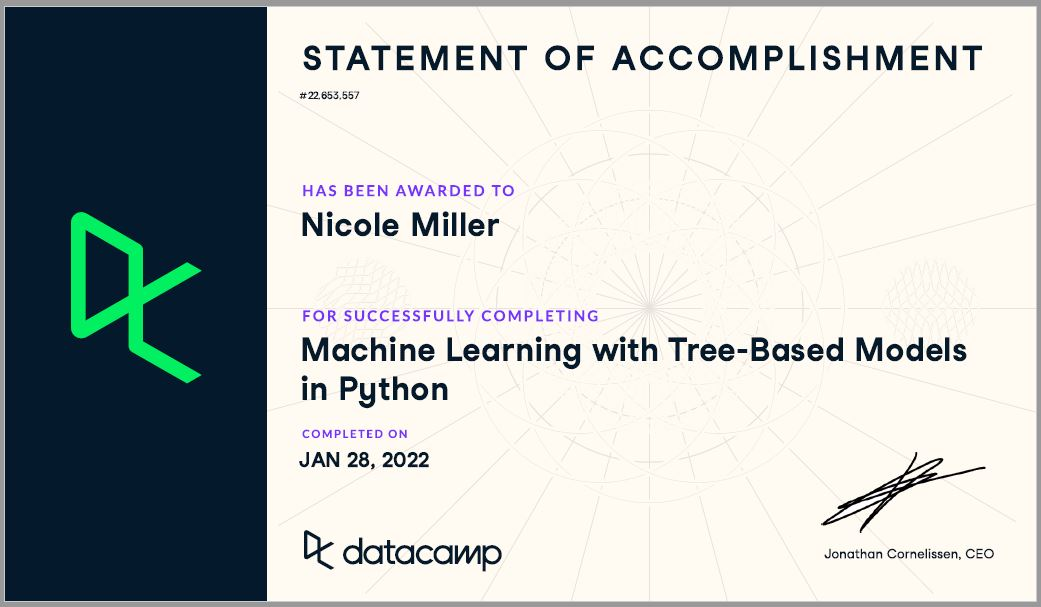